In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style = "whitegrid")
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

D:\Anaconda\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Reading different version of date 

### Case 1: Reading the file without any missing date value

In [9]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
ts = pd.read_csv('../datasets/AirPassengers.csv', index_col='Month',date_parser=dateparse)
ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
number_of_passengers    144 non-null int64
dtypes: int64(1)
memory usage: 2.2 KB


### Case 2: Reading the dataset with missing date value (1949-12 and 1954-02)

In [47]:
ts = pd.read_csv('../datasets/AirPassengers_missing_dates.csv', index_col='Month')

# Converting index to datetime
ts.index = pd.to_datetime(ts.index, format='%Y-%m')
ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
number_of_passengers    144 non-null int64
dtypes: int64(1)
memory usage: 2.2 KB


In [51]:
ts.iloc[[11, 61],:] # NaT: Not a Timestamp

,number_of_passengers
Month,
NaT,118
NaT,188


In [52]:
# Replacing the index with the new date sequence
ts.index = pd.date_range(min(ts.index), max(ts.index), freq='MS') # MS: Month starting date
ts.iloc[[11, 61],:]

,number_of_passengers
1949-12-01,118
1954-02-01,188


### Case 3: Reading the dataset with mixed dates (1949-Dec and 1954-02)

In [53]:
ts = pd.read_csv('../datasets/AirPassengers_mixed_dates.csv', index_col='Month')

In [57]:
# errors="coerce" convert dates to NaT which doesn't match given format
ts.index = pd.to_datetime(ts.index, format='%Y-%m', errors='coerce') 
ts.index = pd.date_range(min(ts.index), max(ts.index), freq='MS') # MS: Month starting date
ts.iloc[[11, 61],:]

,number_of_passengers
1949-12-01,118
1954-02-01,188


# Handling missing data

In [69]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
ts = pd.read_csv('../datasets/AirPassengers_missing_data.csv', index_col='Month',date_parser=dateparse)
ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
number_of_passengers    125 non-null float64
dtypes: float64(1)
memory usage: 2.2 KB


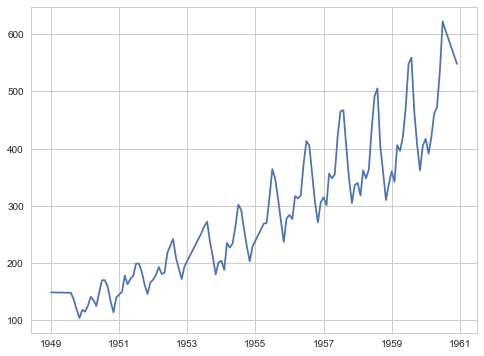

In [91]:
nts = ts.interpolate(method="spline", order=1, limit_direction='both')
plt.figure(figsize=(8,6))
plt.plot(nts.index, nts.number_of_passengers)

# Handling outliers (1950-12: 2000, 1954-08: 1, 1959-09: 6000)

In [111]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
ts = pd.read_csv('../datasets/AirPassengers_outliers.csv', index_col='Month',date_parser=dateparse)
ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
number_of_passengers    144 non-null int64
dtypes: int64(1)
memory usage: 2.2 KB


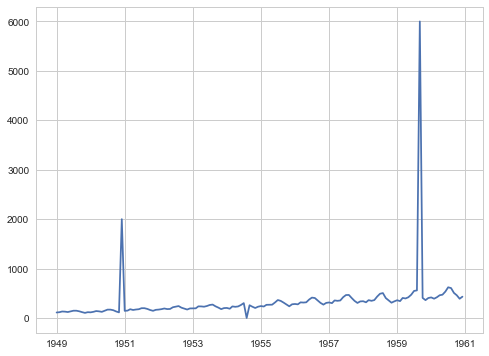

In [112]:
plt.figure(figsize=(8,6))
plt.plot(ts.index, ts.number_of_passengers)

array([2000, 6000], dtype=int64)

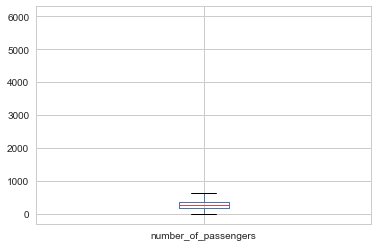

In [130]:
# Finding the outliers
fig, data = ts.boxplot(return_type='both')
outliers = [flier.get_ydata() for flier in f["fliers"]][0]
outliers

In [134]:
# Replacing outliers with NaN and going for forward fill
ts = ts.replace(outliers, np.nan).ffill()

# Decomposition techniques
* Additive
* Multiplicative

In [2]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
ts = pd.read_csv('AirPassengers.csv', index_col='Month',date_parser=dateparse)

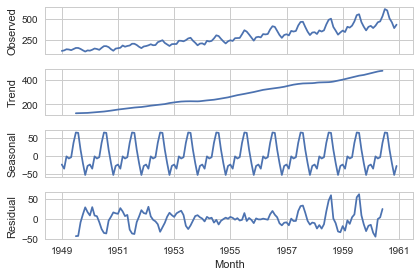

In [143]:
from statsmodels.tsa.seasonal import seasonal_decompose

res = seasonal_decompose(ts, model='additive')
res.plot()
plt.show()

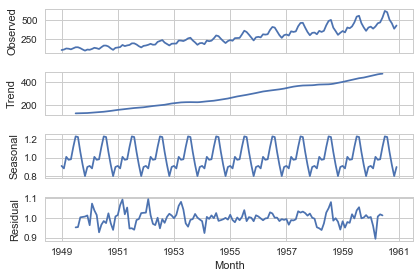

In [144]:
res = seasonal_decompose(ts, model='multiplicative')
res.plot()
plt.show()

# Time Series: checking stationarity using Dickey-Fuller Test
Null Hypothesis $H_0$ = Series is not stationary  
Alternate Hypothesis $H_{alt}$ = Series is stationary  
If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary.

In [40]:
from statsmodels.tsa.stattools import adfuller
adfuller(ts.number_of_passengers, maxlag=0) # p-value: 0.40. Hence, not-stationary

(-1.748092847695433,
 0.4065192861056566,
 0,
 143,
 {'1%': -3.4769274060112707,
  '10%': -2.577665408088415,
  '5%': -2.8819726324025625},
 1412.211518998197)

In [42]:
adfuller(np.diff(np.log(ts.number_of_passengers)), maxlag=0) # p-value: 1.6e-16. Stationary series

(-9.631338431594319,
 1.6091751019746681e-16,
 0,
 142,
 {'1%': -3.477261624048995,
  '10%': -2.5777431104939494,
  '5%': -2.8821181874544233},
 -234.90296075356036)

# Plots: ACF and PACF

In [3]:
nts = np.diff(np.log(ts.number_of_passengers))

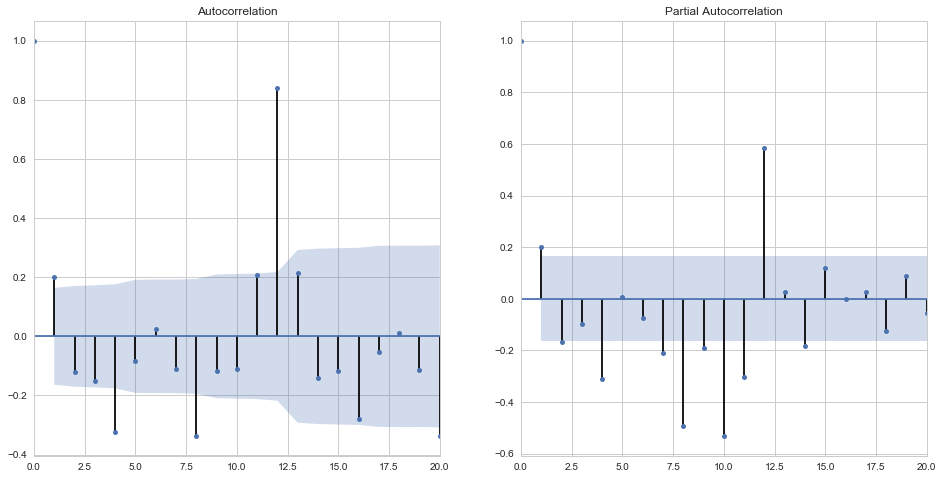

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.figure(figsize=(16,8))
ax1 = plt.subplot(121)
plot_acf(nts,lags=20, ax=ax1)
plt.xlim(0,20)
ax2 = plt.subplot(122)
plot_pacf(nts,lags=20, ax=ax2)
plt.xlim(0,20)
plt.show()

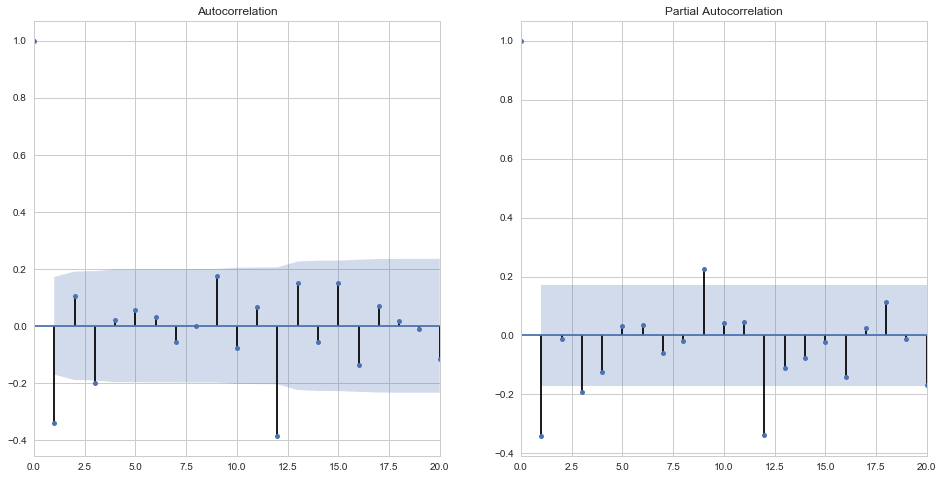

In [6]:
# seasonal differencing
sts = pd.Series(nts)[12:] - pd.Series(nts).shift(periods=12)[12:]

plt.figure(figsize=(16,8))
ax1 = plt.subplot(121)
plot_acf(sts, lags=20, ax=ax1)
plt.xlim(0,20)
ax2 = plt.subplot(122)
plot_pacf(sts, lags=20, ax=ax2)
plt.xlim(0,20)
plt.show()

# p = 1
# q = 1
# P = 1
# Q = 1

In [7]:
sts1 = pd.Series(pd.Series(nts) - pd.Series(nts).shift(periods=12))
sts1.index = ts.index[1:]

In [8]:
# Putting 0 for d and D, since we are using differenced data
model = sm.tsa.statespace.SARIMAX(sts1.iloc[:131], 
                                  order=(1,0,1), 
                                  seasonal_order=(1,0,1, 12)).fit() 

In [9]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  131
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 223.842
Date:                            Fri, 14 Sep 2018   AIC                           -437.684
Time:                                    13:37:16   BIC                           -423.308
Sample:                                02-01-1949   HQIC                          -431.842
                                     - 12-01-1959                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1921      0.245      0.785      0.432      -0.288       0.672
ma.L1         -0.5368      0.219     -2.452      0.014      -0.966      -0.108
ar.S.L12      -0.0684      0.220     -0.312      0.755      -0.499       0.362
ma.S.L12      -0.5186      0.230     -2.255      0.024      -0.969      -0.068
sigma2         0.0013      0.000      7.818      0.000       0.001       0.002
===================================================================================
Ljung-Box (Q):                         nan   Jarque-Bera (JB):                 2.26
Prob(Q):                               nan   Prob(JB):                         0.32
Heteroskedasticity (H):               0.53   Skew:                            -0.02
Prob(H) (two-sided):                  0.05   Kurtosis:                         3.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [17]:
est = model.forecast(12)
np.exp(est)

1960-01-01    0.966480
1960-02-01    0.998667
1960-03-01    0.983753
1960-04-01    0.997970
1960-05-01    0.982166
1960-06-01    1.031436
1960-07-01    0.978854
1960-08-01    0.993535
1960-09-01    1.006876
1960-10-01    0.998529
1960-11-01    0.988062
1960-12-01    0.992629
Freq: MS, dtype: float64

In [16]:
ts.iloc[131:]

,number_of_passengers
Month,
1959-12-01,405
1960-01-01,417
1960-02-01,391
1960-03-01,419
1960-04-01,461
1960-05-01,472
1960-06-01,535
1960-07-01,622
1960-08-01,606
